In [66]:
import torchvision 
import numpy as np
import torch
import torch.autograd as autograd
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter
import torch.nn as nn
import pylab as pl
import time
import math
import pickle
from IPython import display
import torch.nn.functional as F
from copy import deepcopy
import cifarResnet
from torchsummary import summary
from matplotlib import pyplot as plt
from scipy.misc import bytescale

torch.cuda.set_device(3) # Set gpu number here

# Prepare CIFAR100 data

In [2]:
train_set = torchvision.datasets.CIFAR100(root='/data/xay2/cifar100', train=True, download=True)
test_set = torchvision.datasets.CIFAR100(root='/data/xay2/cifar100', train=False, download=True)
with open('/data/xay2/cifar100/cifar-100-python/train', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')
    train_data = d[b'data'].reshape(-1,3,32,32)
    train_labels = np.array(d[b'fine_labels'])
with open('/data/xay2/cifar100/cifar-100-python/test', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')
    testdata = d[b'data'].reshape(-1,3,32,32)
    testlabels = np.array(d[b'fine_labels'])
    
train_size = 40000
val_size = 10000
traindata = train_data[:train_size]
trainlabels = train_labels[:train_size]
valdata = train_data[train_size:train_size+val_size]
vallabels = train_labels[train_size:train_size + val_size]

traindata = torch.Tensor(traindata.astype(np.float64))
trainlabels = torch.Tensor(trainlabels.astype(np.float64)).long()
valdata = torch.Tensor(valdata.astype(np.float64))
vallabels = torch.Tensor(vallabels.astype(np.float64)).long()
testdata = torch.Tensor(testdata.astype(np.float64))
testlabels = torch.Tensor(testlabels.astype(np.float64)).long()


standardize = torchvision.transforms.Normalize(mean=[125.3, 123, 113.9],std=[63, 62.1, 66.7])
traindata = torch.cat([standardize(traindata[i]).view(1,3,32,32) for i in range(len(traindata))],dim=0).float()
valdata = torch.cat([standardize(valdata[i]).view(1,3,32,32) for i in range(len(valdata))],dim=0).float()
testdata = torch.cat([standardize(testdata[i]).view(1,3,32,32) for i in range(len(testdata))],dim=0).float()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#get first N images from label class L 
def get_N_cifar_images(N, L, images, labels):
    query_images = []
    n = len(labels)
    for i in range(n):
        if labels[i] == L:
            query_images.append(images[i])
            N-=1
            if N == 0:
                break
    query_images = np.stack(query_images)
    query_images = torch.Tensor(query_images)
    return query_images

In [39]:
# number of images per class
N=1
finetune_data = torch.cat([get_N_cifar_images(N, i, traindata, trainlabels) for i in range(100)], dim=0).float()
y = torch.arange(100,dtype=torch.long).view(-1,1)
y = y.repeat(1,N)
finetune_labels = y.view(y.nelement())
print(finetune_data.size())
print(finetune_labels.size())

torch.Size([100, 3, 32, 32])
torch.Size([100])


(32, 32, 3)


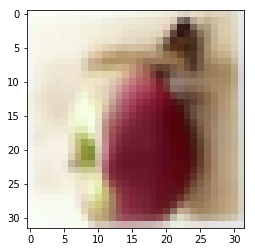

(32, 32, 3)


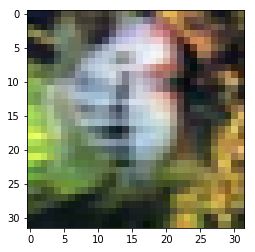

(32, 32, 3)


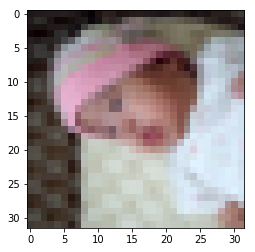

(32, 32, 3)


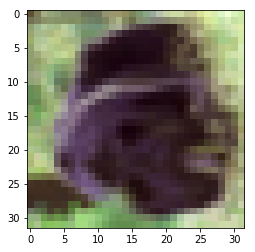

(32, 32, 3)


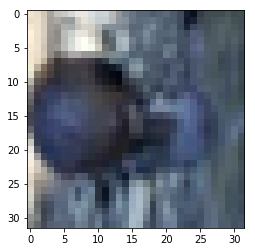

(32, 32, 3)


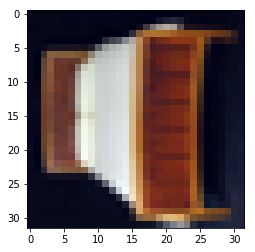

(32, 32, 3)


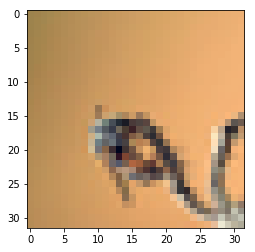

(32, 32, 3)


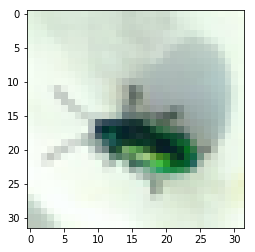

(32, 32, 3)


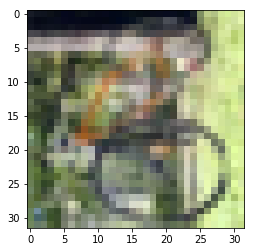

(32, 32, 3)


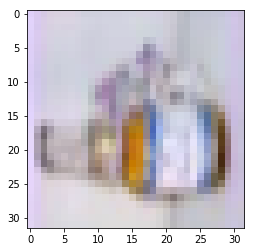

(32, 32, 3)


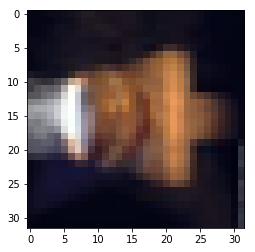

(32, 32, 3)


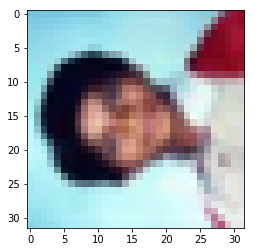

(32, 32, 3)


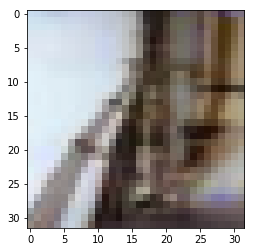

(32, 32, 3)


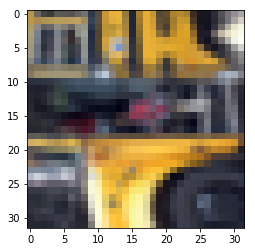

(32, 32, 3)


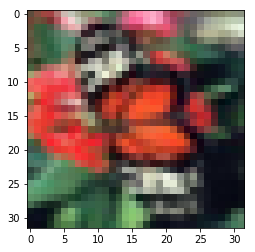

(32, 32, 3)


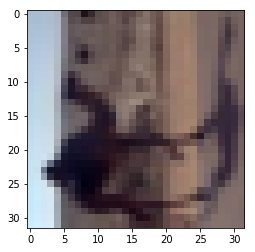

(32, 32, 3)


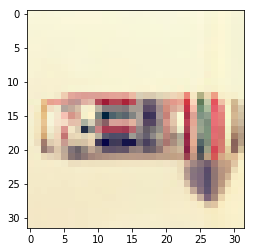

(32, 32, 3)


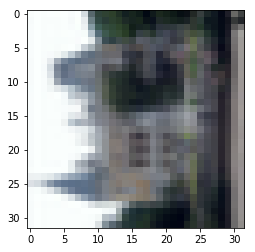

(32, 32, 3)


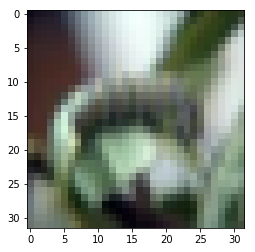

(32, 32, 3)


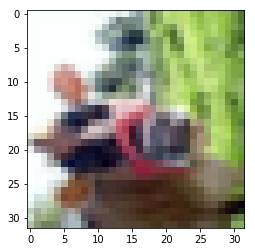

(32, 32, 3)


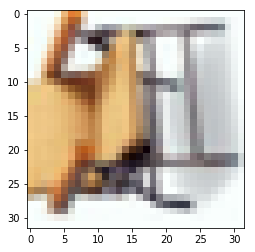

(32, 32, 3)


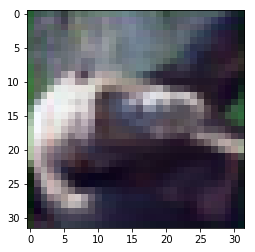

(32, 32, 3)


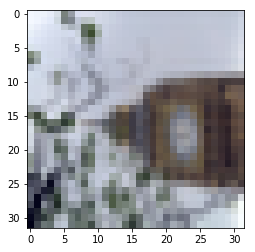

(32, 32, 3)


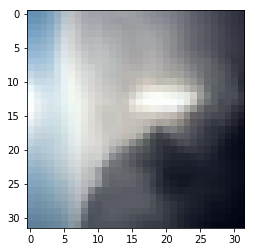

(32, 32, 3)


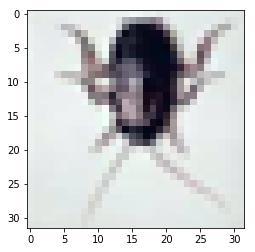

(32, 32, 3)


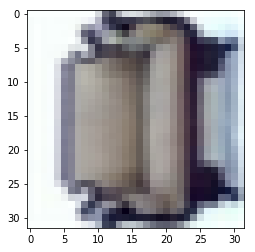

(32, 32, 3)


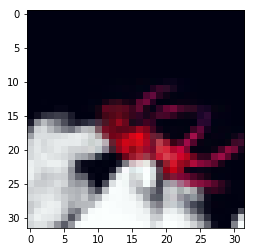

(32, 32, 3)


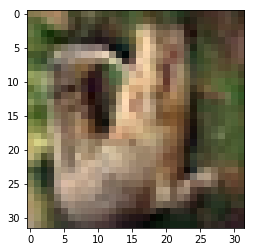

(32, 32, 3)


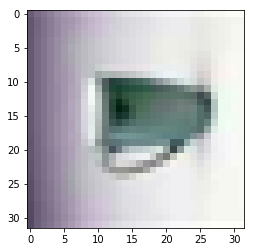

(32, 32, 3)


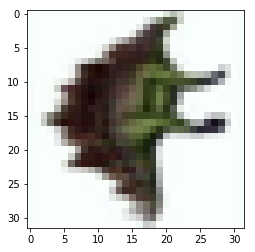

(32, 32, 3)


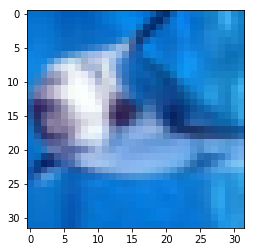

(32, 32, 3)


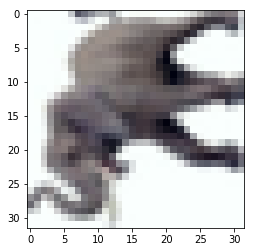

(32, 32, 3)


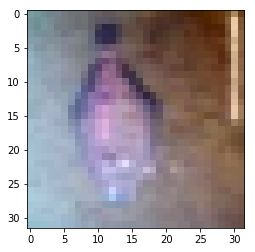

(32, 32, 3)


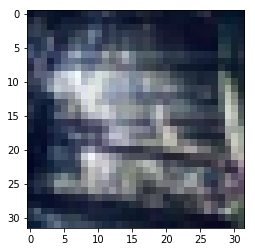

(32, 32, 3)


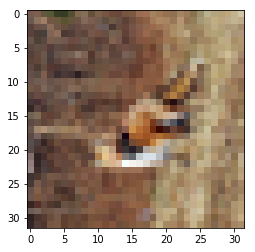

(32, 32, 3)


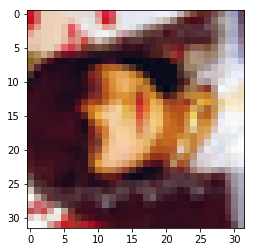

(32, 32, 3)


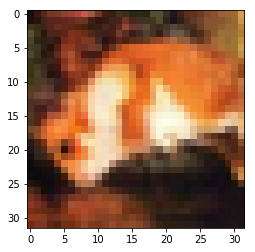

(32, 32, 3)


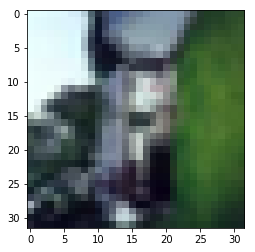

(32, 32, 3)


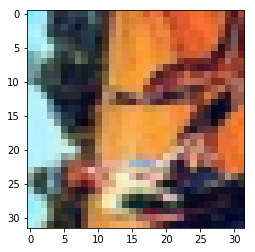

(32, 32, 3)


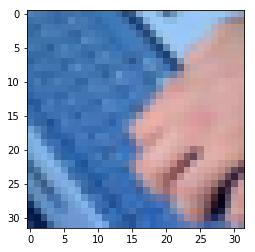

(32, 32, 3)


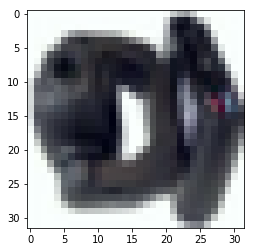

(32, 32, 3)


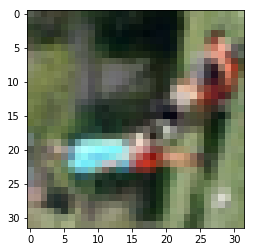

(32, 32, 3)


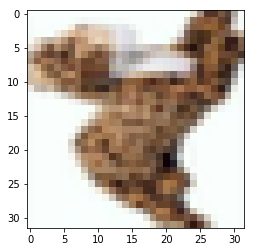

(32, 32, 3)


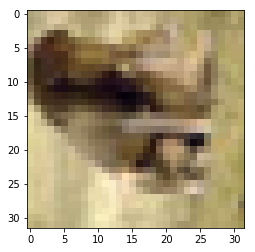

(32, 32, 3)


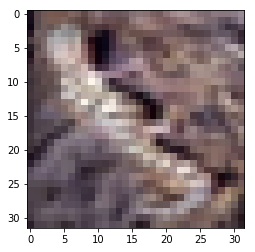

(32, 32, 3)


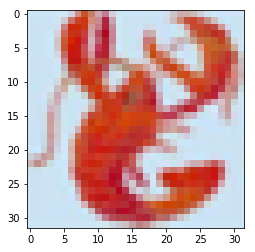

(32, 32, 3)


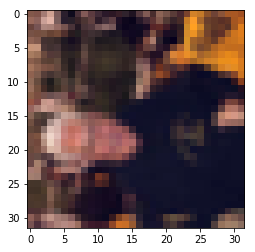

(32, 32, 3)


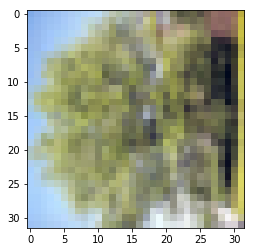

(32, 32, 3)


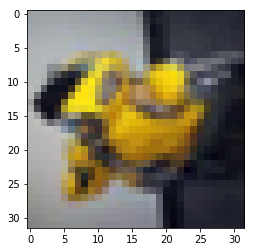

(32, 32, 3)


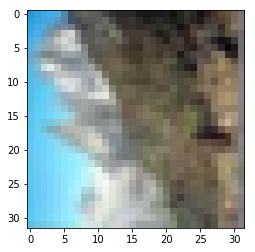

(32, 32, 3)


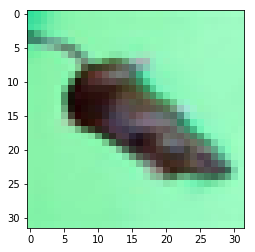

(32, 32, 3)


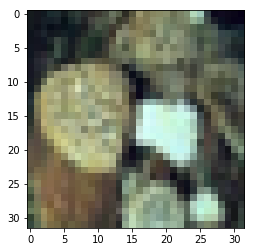

(32, 32, 3)


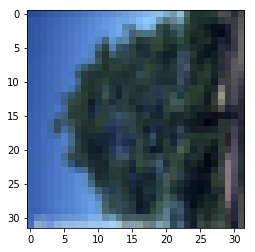

(32, 32, 3)


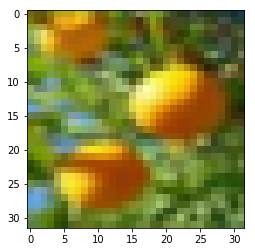

(32, 32, 3)


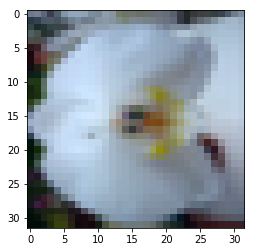

(32, 32, 3)


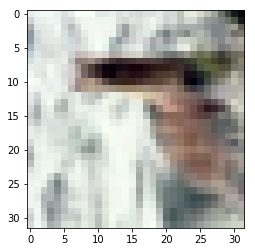

(32, 32, 3)


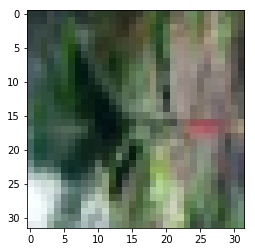

(32, 32, 3)


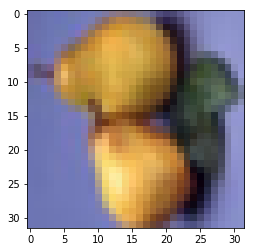

(32, 32, 3)


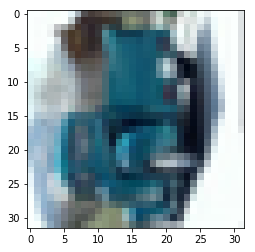

(32, 32, 3)


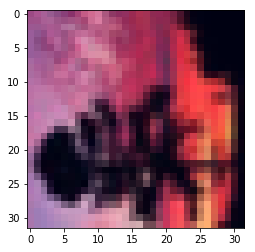

(32, 32, 3)


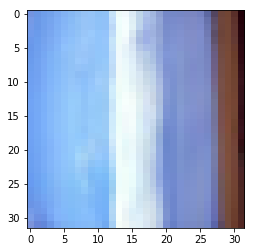

(32, 32, 3)


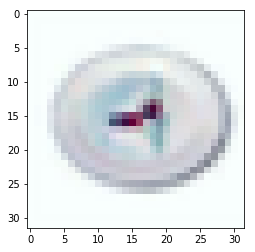

(32, 32, 3)


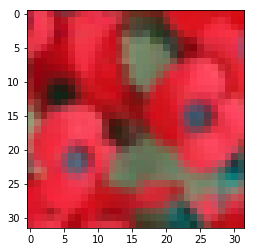

(32, 32, 3)


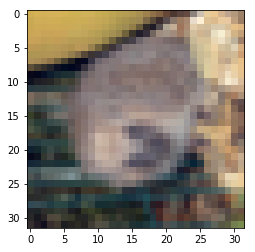

(32, 32, 3)


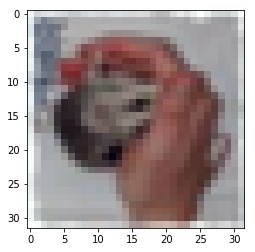

(32, 32, 3)


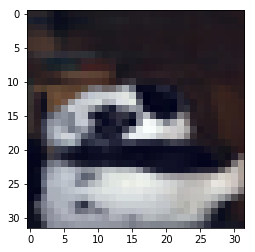

(32, 32, 3)


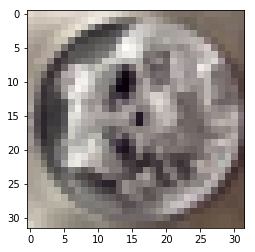

(32, 32, 3)


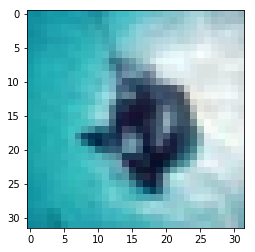

(32, 32, 3)


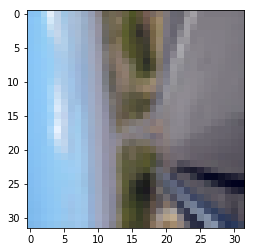

(32, 32, 3)


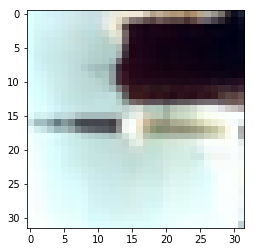

(32, 32, 3)


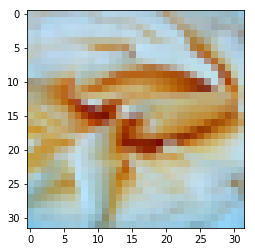

(32, 32, 3)


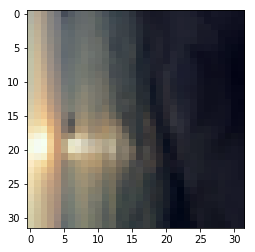

(32, 32, 3)


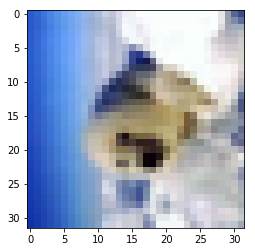

(32, 32, 3)


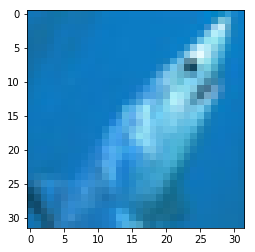

(32, 32, 3)


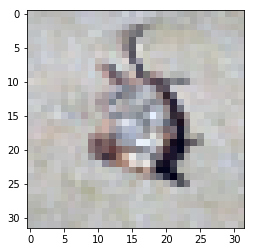

(32, 32, 3)


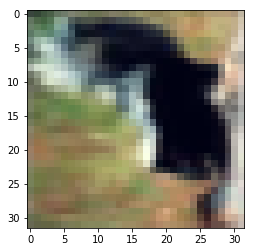

(32, 32, 3)


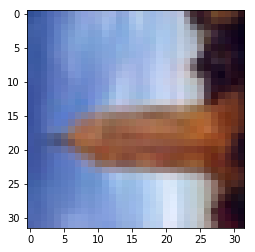

(32, 32, 3)


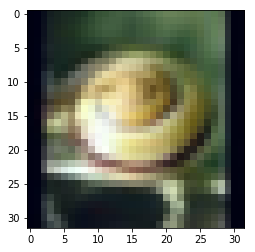

(32, 32, 3)


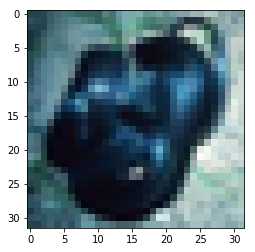

(32, 32, 3)


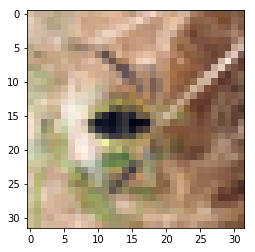

(32, 32, 3)


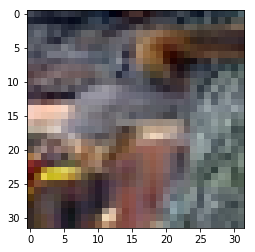

(32, 32, 3)


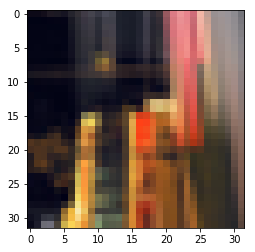

(32, 32, 3)


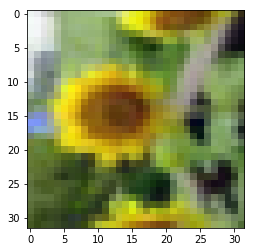

(32, 32, 3)


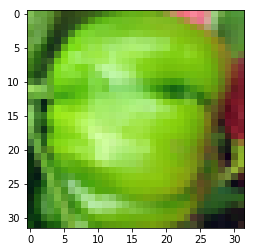

(32, 32, 3)


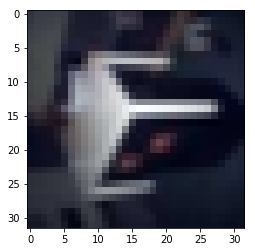

(32, 32, 3)


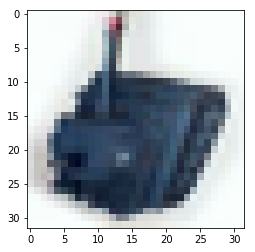

(32, 32, 3)


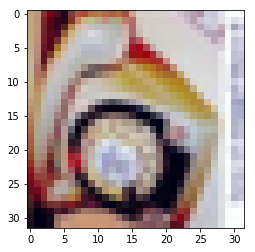

(32, 32, 3)


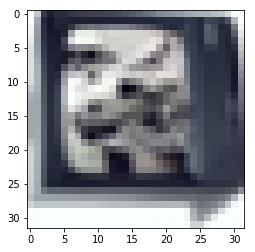

(32, 32, 3)


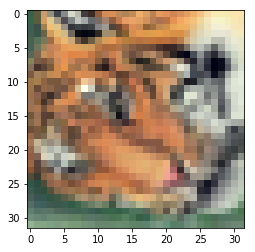

(32, 32, 3)


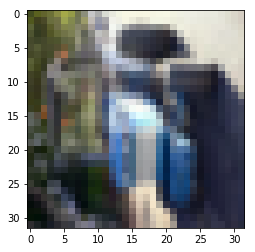

(32, 32, 3)


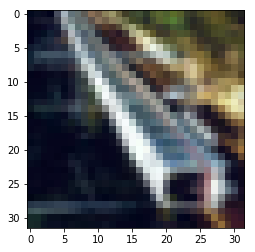

(32, 32, 3)


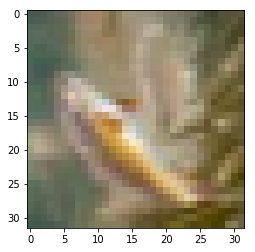

(32, 32, 3)


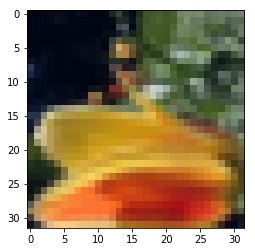

(32, 32, 3)


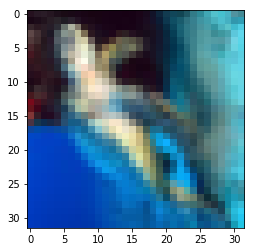

(32, 32, 3)


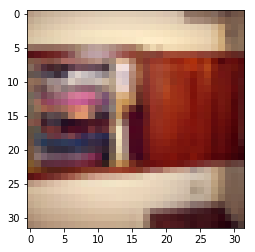

(32, 32, 3)


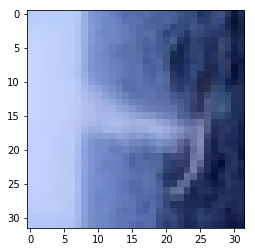

(32, 32, 3)


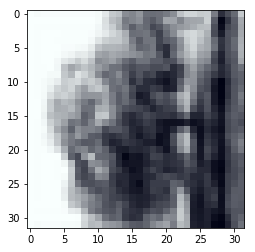

(32, 32, 3)


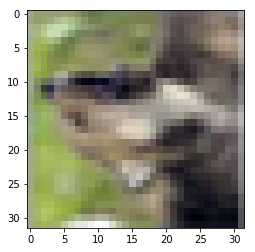

(32, 32, 3)


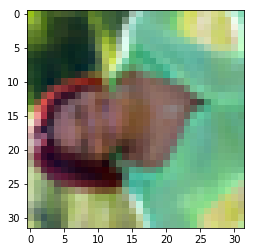

(32, 32, 3)


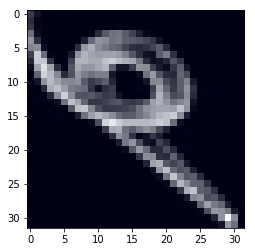

In [68]:
def  show_image(data):
    '''
    Given an image-like array, plot it as an image.
    
    Parameters:
        data: an array shaped like an image (could be RGB or grayscale)
    '''
    data = bytescale(data)
    plt.imshow(data, interpolation='nearest')
    plt.show()

#visualize training images
for i in range(100):
    img = finetune_data[i].numpy().transpose(2,1,0)
    print(img.shape)
    show_image(img)

# Load model and finetuning 

In [6]:
# Define our helper functions

def alter(t):
    # flip and crop
    if np.random.random(1) > .5:
        inv_idx = torch.arange(t.size(2)-1,-1,-1).long()
        result = t[:,:,inv_idx]
    else:
        result = t
    result = F.pad(result.view(1,3,32,32),(4,4,4,4)).data
    x = np.random.randint(0,high=9)
    y = np.random.randint(0,high=9)
    return result[0,:,x:x+32,y:y+32].contiguous()

def batchmaker(theset, thelabels, shot=100, alterful=False):
    batch = np.random.choice(len(theset),shot,replace=False)
    data = (torch.cat([alter(theset[i]).view(1,3,32,32) for i in batch],dim=0).float()
            if alterful else
            torch.cat([theset[i].view(1,3,32,32) for i in batch],dim=0).float())
    labels = torch.LongTensor(np.array([thelabels[i] for i in batch]))
    
    return(Variable(data).cuda(),
           Variable(labels).cuda()
          )

criterion = nn.CrossEntropyLoss().cuda()

def evaluate(model, criterion, testing_data, testing_labels, shot=1000):
    support, targs = batchmaker(testing_data, testing_labels, shot=shot)
    c = 200
    assert shot%c==0
    batches = int(shot//c)
    support = support.view(batches, c, 3, 32, 32)
    targs = targs.view(batches, c)
    acc = 0
    loss = 0
    with torch.no_grad():
        for i in range(batches):
            preds = model(support[i,:,:,:,:])
            loss += criterion(preds, targs[i,:]).data[0]
            _,bins = torch.max(preds, 1)
            acc += torch.sum(torch.eq(bins,targs[i,:])).data[0]
    acc = float(acc)/shot
    loss = float(loss)/batches
    return loss, acc

In [45]:
model = cifarResnet.ResNet(9,16).cuda()
checkpoint = torch.load('/data/xay2/scripts/pretrained_resnet/cifar10.pth')
model.load_state_dict(checkpoint)

# freeze the feature extractors 
for param in model.parameters():
    param.requires_grad = False

i = model.fc.in_features
model.fc = nn.Linear(i,100).cuda()

In [47]:
child_counter = 0
for child in model.children():
    print(" child", child_counter, "is:")
    print(child)    
    child_counter += 1
'''
for param in model.parameters():
    print(param.size())
    print(param.requires_grad)
'''
summary(model,(3,32,32))

 child 0 is:
Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 child 1 is:
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace)
 child 3 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-

Approximately 0.00 hours to completion


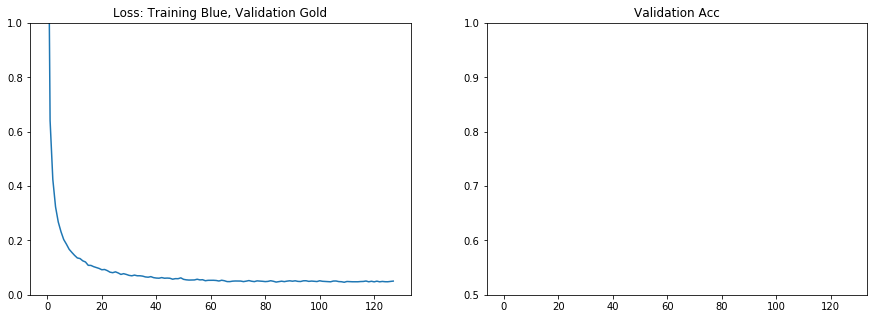

Train loss is: 0.050428391829133036
Validation accuracy is: 0.0582
Validation loss is: 10.016712036132812

[]
Average score is 0.0582


'\nif len(ensemble) > 1:\n    print("95% confidence interval is", np.sqrt(np.var(allscores)/len(ensemble))*1.96)\n'

In [48]:
# Train!

%matplotlib inline

vbity = 500
epoch = 16000
limit = 64000
ensemble = list(range(1)) # Set the number of models that you want to train here
allscores = []
alltrainloss = []
alltestloss = []
start = time.time()
for b in ensemble:
    #model = cifarResnet.ResNet(9,16).cuda()
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),lr=.1,weight_decay=.0001,momentum=.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: min(1/(10**(x)),.1))
    losstracker = []
    evalacctracker = []
    evallosstracker = []
    runningloss = 0
    for it in range(limit):
        if it%50==0:
            print(it)

        # Build batch
        support, targs = batchmaker(finetune_data, finetune_labels, alterful=True, shot=20)
        print(support.size())
        # Predict
        model.zero_grad()
        preds =model(support)

        # Calculate Loss
        loss = criterion(preds, targs)
        runningloss += loss.item()

        # Backprop
        if it%epoch == 0:
            scheduler.step()
        loss.backward()
    #     nn.utils.clip_grad_norm(model.parameters(), 1)
        optimizer.step()

        # Report
        if it%vbity == vbity-1:
            display.clear_output(wait=True)
            print("Approximately %.2f hours to completion"%(
                (time.time()-start)/(it+1+b*limit)*((len(ensemble)-b)*limit-it)/3600))

            losstracker.append(runningloss/vbity)
            model = model.eval()
            evalloss, evalacc = evaluate(model, criterion, valdata, vallabels, shot=10000)
            model = model.train()
            evallosstracker.append(evalloss)
            evalacctracker.append(evalacc)

            pl.figure(1,figsize=(15,5))
            pl.subplot(1,2,1)
            pl.plot(losstracker)
            pl.plot(evallosstracker)
            pl.ylim((0,1))
    #         pl.xlim((0,limit*epoch))
            pl.title("Loss: Training Blue, Validation Gold")
            pl.subplot(1,2,2)
            pl.plot(evalacctracker[::-1])
            pl.ylim((0.5,1))
    #         pl.xlim((0,limit*epoch))
            pl.title("Validation Acc")
            pl.show()

            print("Train loss is: "+str(runningloss/vbity)+
                  "\nValidation accuracy is: "+str(evalacc)+
                  "\nValidation loss is: "+str(evalloss)+"\n")
            runningloss = 0
            print(allscores)
    model.eval()
    _,score = evaluate(model, criterion, valdata, vallabels, shot=10000)
    allscores.append(score)
    alltrainloss.append(losstracker)
    alltestloss.append(evallosstracker)
    
print("Average score is", np.mean(allscores))
'''
if len(ensemble) > 1:
    print("95% confidence interval is", np.sqrt(np.var(allscores)/len(ensemble))*1.96)
'''

In [72]:

model.eval()
preds=model(Variable(finetune_data[6]).cuda().view(-1,3,32,32))
_,bins = torch.max(preds, 1)
print(bins)
print(finetune_labels[6])

tensor([ 6], device='cuda:3')
tensor(6)
